Goals:

Investigate the data, and do any necessary data cleaning.

Explore the data and find some variables that you think would be useful in predicting house prices.

Build your initial model using these features and estimate the parameters using OLS.

In [80]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [3]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
houseprices_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houseprices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [3]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

<IPython.core.display.Javascript object>

### Distribution of Target Variable

First thing is to look at how our target variable is distributed and see if we need to transform it.  This step will inform the rest of our analysis.

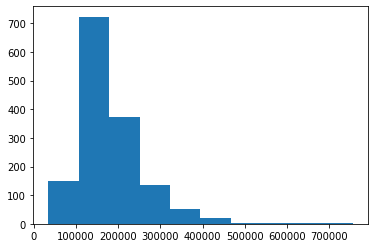

<IPython.core.display.Javascript object>

In [6]:
plt.hist(houseprices_df.saleprice)
plt.show()

Because this does not appear to be normally distributed, we should log transform it to make future analysis easier.

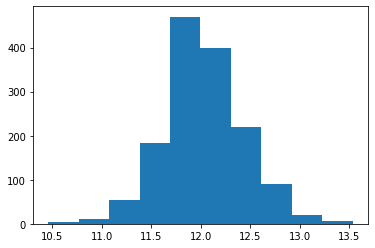

<IPython.core.display.Javascript object>

In [10]:
houseprices_df["log_price"] = np.log(houseprices_df["saleprice"])

# check to see that the distribution is more normal
plt.hist(houseprices_df.log_price)
plt.show()

### Missingness

Let's look into missingness and see if there are any features we can discard because they are missing too many values.

In [4]:
houseprices_df.isna().mean().sort_values(ascending=False).head(20)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
dtype: float64

<IPython.core.display.Javascript object>

Because poolqc, miscfeature, alley, fence, and fireplacequ are missing so frequently, and because we don't have the domain knowledge to know what this missingness means or whether we can safely impute these values, we'll drop these from the dataset.

In [11]:
houseprices_df = houseprices_df.drop(
    columns=["poolqc", "miscfeature", "alley", "fence", "fireplacequ"]
)

<IPython.core.display.Javascript object>

In [12]:
# checking these were actually dropped
houseprices_df.isna().mean().sort_values(ascending=False).head()

lotfrontage     0.177397
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
dtype: float64

<IPython.core.display.Javascript object>

The last feature that's missing more than 5% of its values is lotfrontage.  Let's see how strong of an effect this has on our target, saleprice...

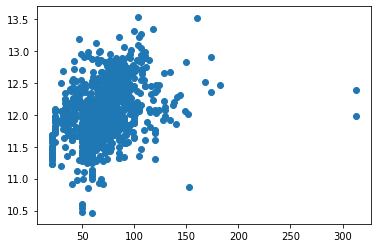

<IPython.core.display.Javascript object>

In [15]:
plt.scatter(houseprices_df["lotfrontage"], houseprices_df["log_price"])
plt.show()

In [30]:
d = {
    "lotfront": houseprices_df.lotfrontage.values,
    "log_price": houseprices_df.log_price.values,
}
lotfront_df = pd.DataFrame(data=d)
lotfront_df.dropna().corr()

,lotfront,log_price
lotfront,1.000000,0.355878
log_price,0.355878,1.000000


<IPython.core.display.Javascript object>

Because the correlation is not very strong, we'll drop this column, too.  Furthermore, we'll drop the rest of the nan's because there are so few.

In [32]:
houseprices_df = houseprices_df.drop(columns=["lotfrontage"]).dropna()

<IPython.core.display.Javascript object>

In [34]:
#verifying that the drop occurred...
houseprices_df.isna().mean().sort_values(ascending=False)

log_price       0.0
foundation      0.0
roofmatl        0.0
exterior1st     0.0
exterior2nd     0.0
               ... 
kitchenqual     0.0
totrmsabvgrd    0.0
functional      0.0
fireplaces      0.0
id              0.0
Length: 76, dtype: float64

<IPython.core.display.Javascript object>

In [35]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 76 columns):
id               1338 non-null int64
mssubclass       1338 non-null int64
mszoning         1338 non-null object
lotarea          1338 non-null int64
street           1338 non-null object
lotshape         1338 non-null object
landcontour      1338 non-null object
utilities        1338 non-null object
lotconfig        1338 non-null object
landslope        1338 non-null object
neighborhood     1338 non-null object
condition1       1338 non-null object
condition2       1338 non-null object
bldgtype         1338 non-null object
housestyle       1338 non-null object
overallqual      1338 non-null int64
overallcond      1338 non-null int64
yearbuilt        1338 non-null int64
yearremodadd     1338 non-null int64
roofstyle        1338 non-null object
roofmatl         1338 non-null object
exterior1st      1338 non-null object
exterior2nd      1338 non-null object
masvnrtype       1338 non-

<IPython.core.display.Javascript object>

### Choosing most highly correlated numerical features

In [37]:
numeric_columns = houseprices_df.select_dtypes(["int64", "float64"]).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saleprice', 'log_price'],
      dtype='object')
The number of numerical columns is 38


<IPython.core.display.Javascript object>

In [56]:
np.abs(
    houseprices_df[numeric_columns].iloc[:, 1:].corr().loc[:, "log_price"]
).sort_values(ascending=False).head(20)

log_price       1.000000
saleprice       0.954241
overallqual     0.807486
grlivarea       0.704739
garagecars      0.660141
garagearea      0.612695
fullbath        0.612604
firstflrsf      0.599786
totalbsmtsf     0.589520
yearbuilt       0.572592
yearremodadd    0.565870
totrmsabvgrd    0.551437
garageyrblt     0.536262
fireplaces      0.470671
masvnrarea      0.423314
openporchsf     0.346072
bsmtfinsf1      0.342070
wooddecksf      0.317555
secondflrsf     0.308708
halfbath        0.286409
Name: log_price, dtype: float64

<IPython.core.display.Javascript object>

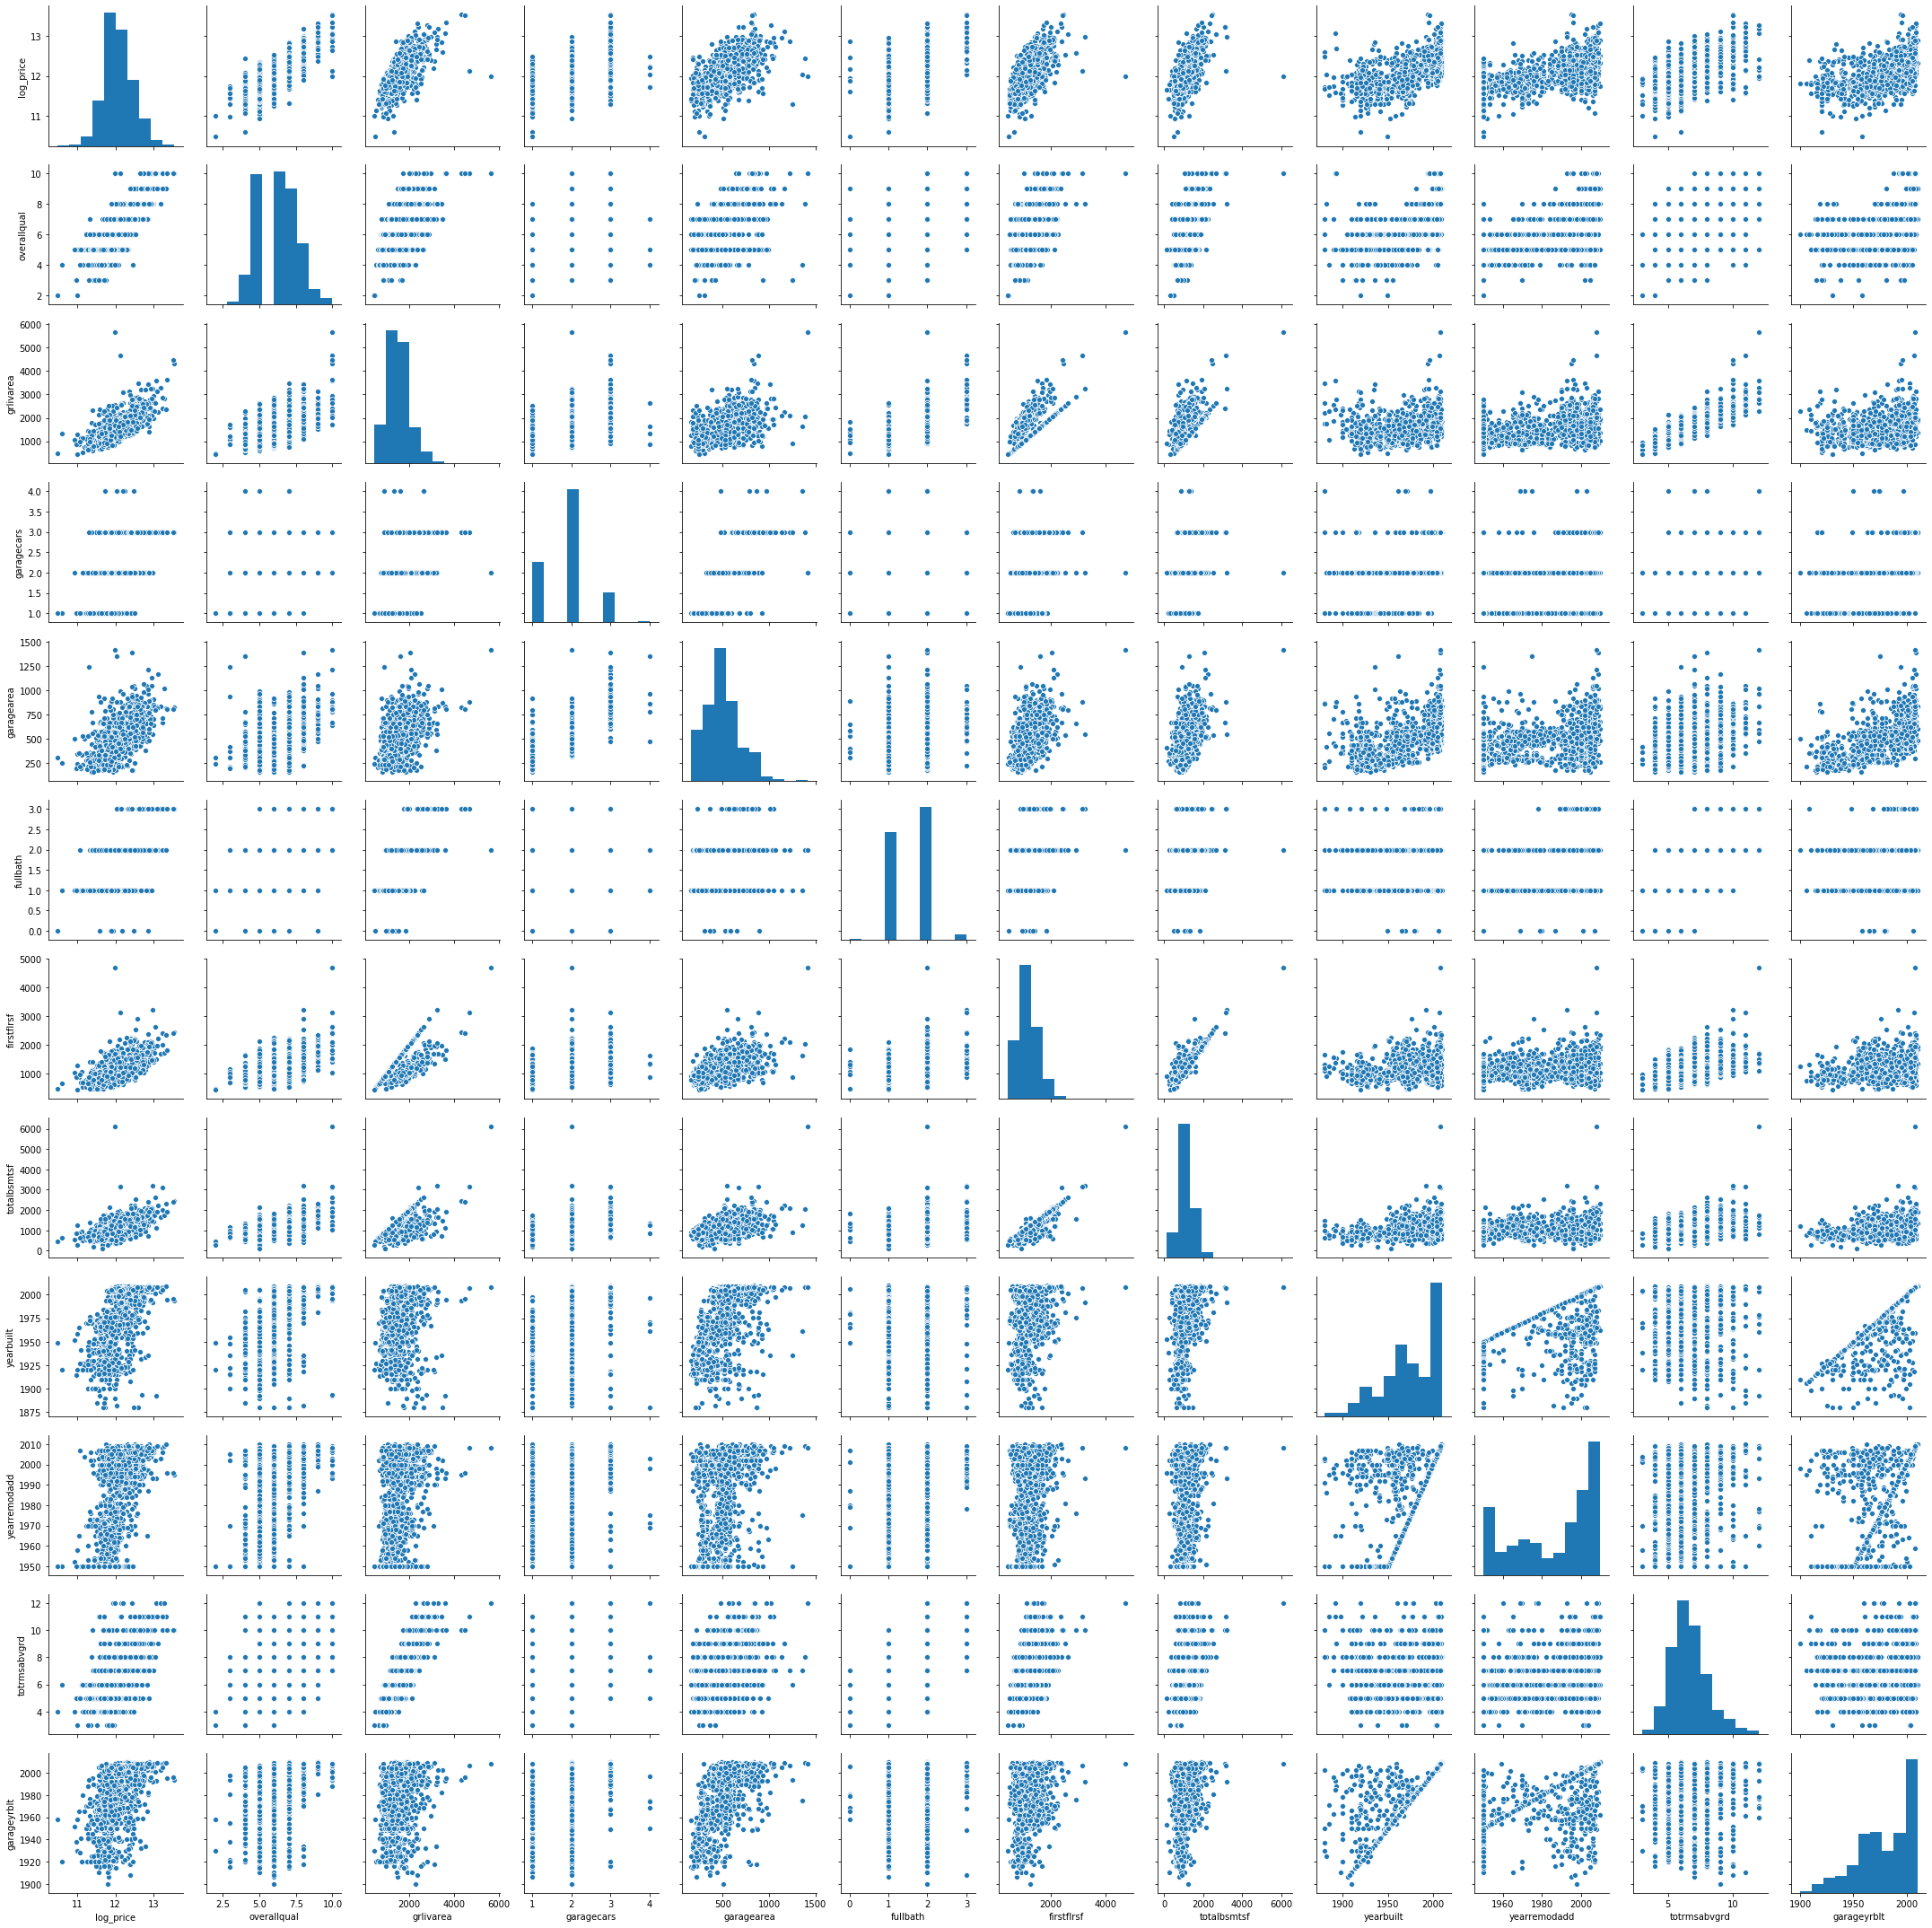

<IPython.core.display.Javascript object>

In [66]:
#selecting onl features that correlated with log_price higher than 50%
high_corr_num_df = houseprices_df[
    [
        "log_price",
        "overallqual",
        "grlivarea",
        "garagecars",
        "garagearea",
        "fullbath",
        "firstflrsf",
        "totalbsmtsf",
        "yearbuilt",
        "yearremodadd",
        "totrmsabvgrd",
        "garageyrblt",
        #                                    "fireplaces","masvnrarea","openporchsf","bsmtfinsf1",
        #                                    "wooddecksf","secondflrsf"
    ]
]
#pairplotting to perhaps spot outliers and multicollinearity
plt.figure(figsize=(30, 50))
sns.pairplot(high_corr_num_df)

From the plots above we see some lines that are suggesting a high amount of collinearity between variables: 
1. firstflrsf and totalbsmtsf nad grlivarea : all have to do with area
2. yearbuilt and yearremodadd and garageyrblt : all have to do with year built

I'm choosing the most correlated of each of these two categories to work with: grlivarea and yearbuilt. I'm also selecting overallqual, garagecars, garagearea, fullbath, and totrmsabvgrd.  Let's take a closer look at the pared down correlations.

<Figure size 2160x3600 with 0 Axes>

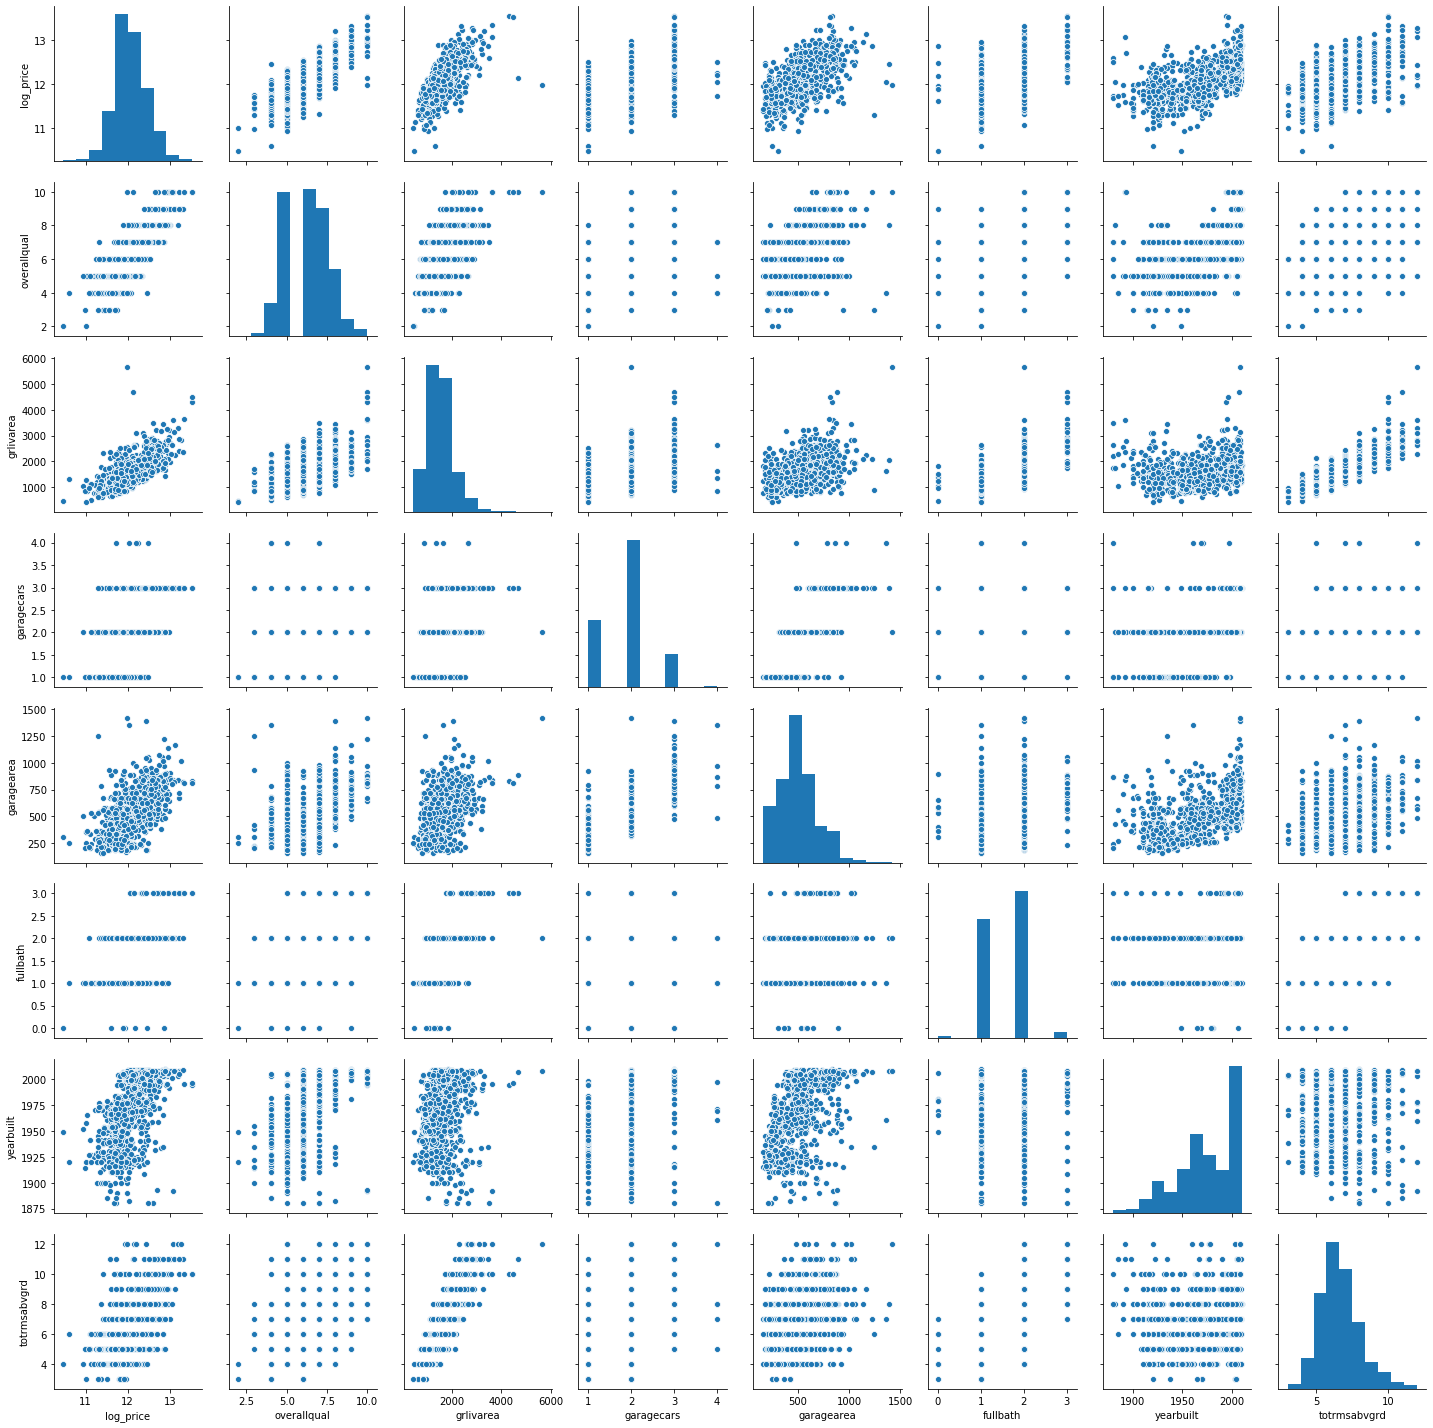

<IPython.core.display.Javascript object>

In [67]:
# selecting onl features that correlated with log_price higher than 50%
high_corr_num_df = houseprices_df[
    [
        "log_price",
        "overallqual",
        "grlivarea",
        "garagecars",
        "garagearea",
        "fullbath",
        "yearbuilt",
        "totrmsabvgrd"
    ]
]
# pairplotting to perhaps spot outliers and multicollinearity
plt.figure(figsize=(30, 50))
sns.pairplot(high_corr_num_df)
plt.show()

I see from the plots that there are a few houses that appear to have a much larger grlivarea than their price would suggest.  Let's drop these outliers:

Dropping house ids [1298, 523, 1182, 691]


<Figure size 2160x3600 with 0 Axes>

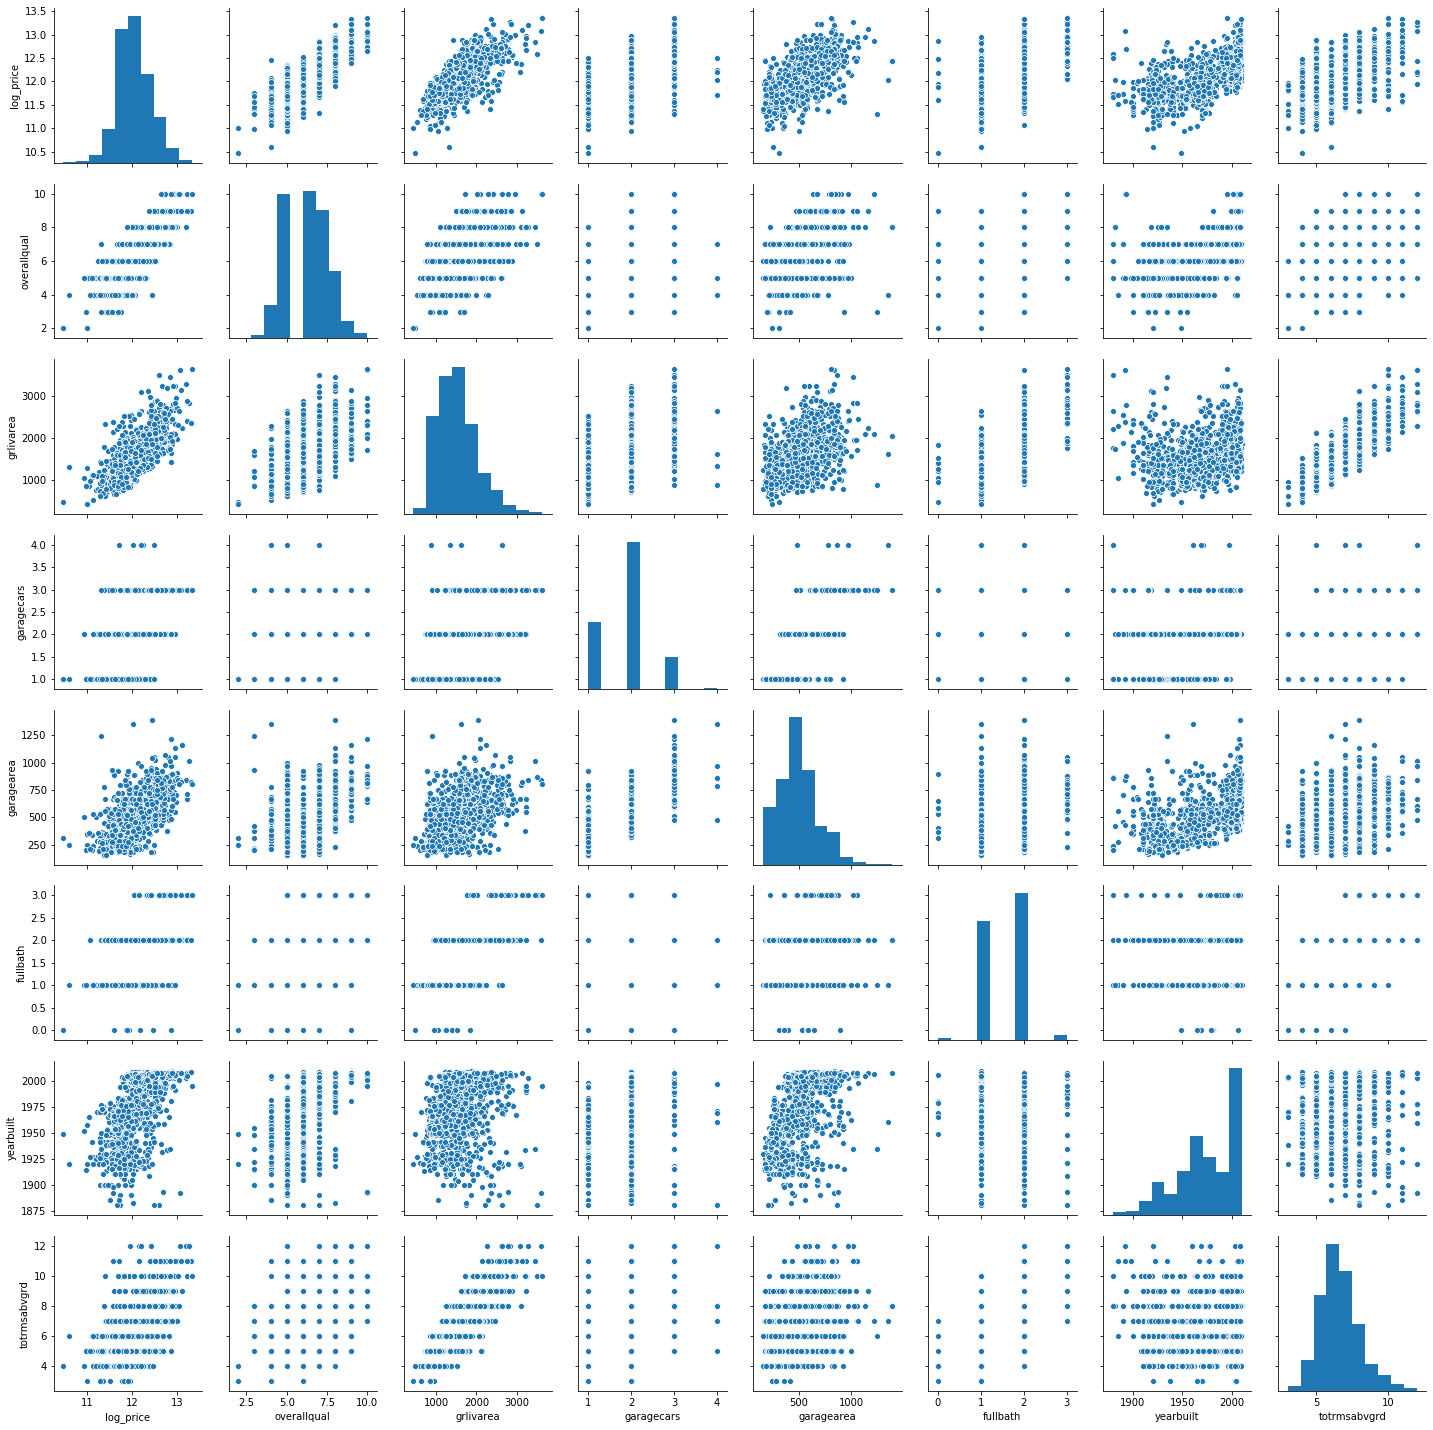

<IPython.core.display.Javascript object>

In [71]:
drop_ids = high_corr_num_df.sort_values("grlivarea", ascending=False).iloc[:4].index
print(f"Dropping house ids {list(drop_ids)}")
high_corr_num_df = high_corr_num_df.drop(index=drop_ids)

# replot without outliers
plt.figure(figsize=(30, 50))
sns.pairplot(high_corr_num_df)
plt.show()

Okay, so now we have all of our most highly correlated numerical features stored in high_corr_num_df.  Let's now focus on the categorical variables.

### Choosing most highly correlated categorical features

In [72]:
non_numeric_columns = houseprices_df.select_dtypes(["object"]).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 38


<IPython.core.display.Javascript object>

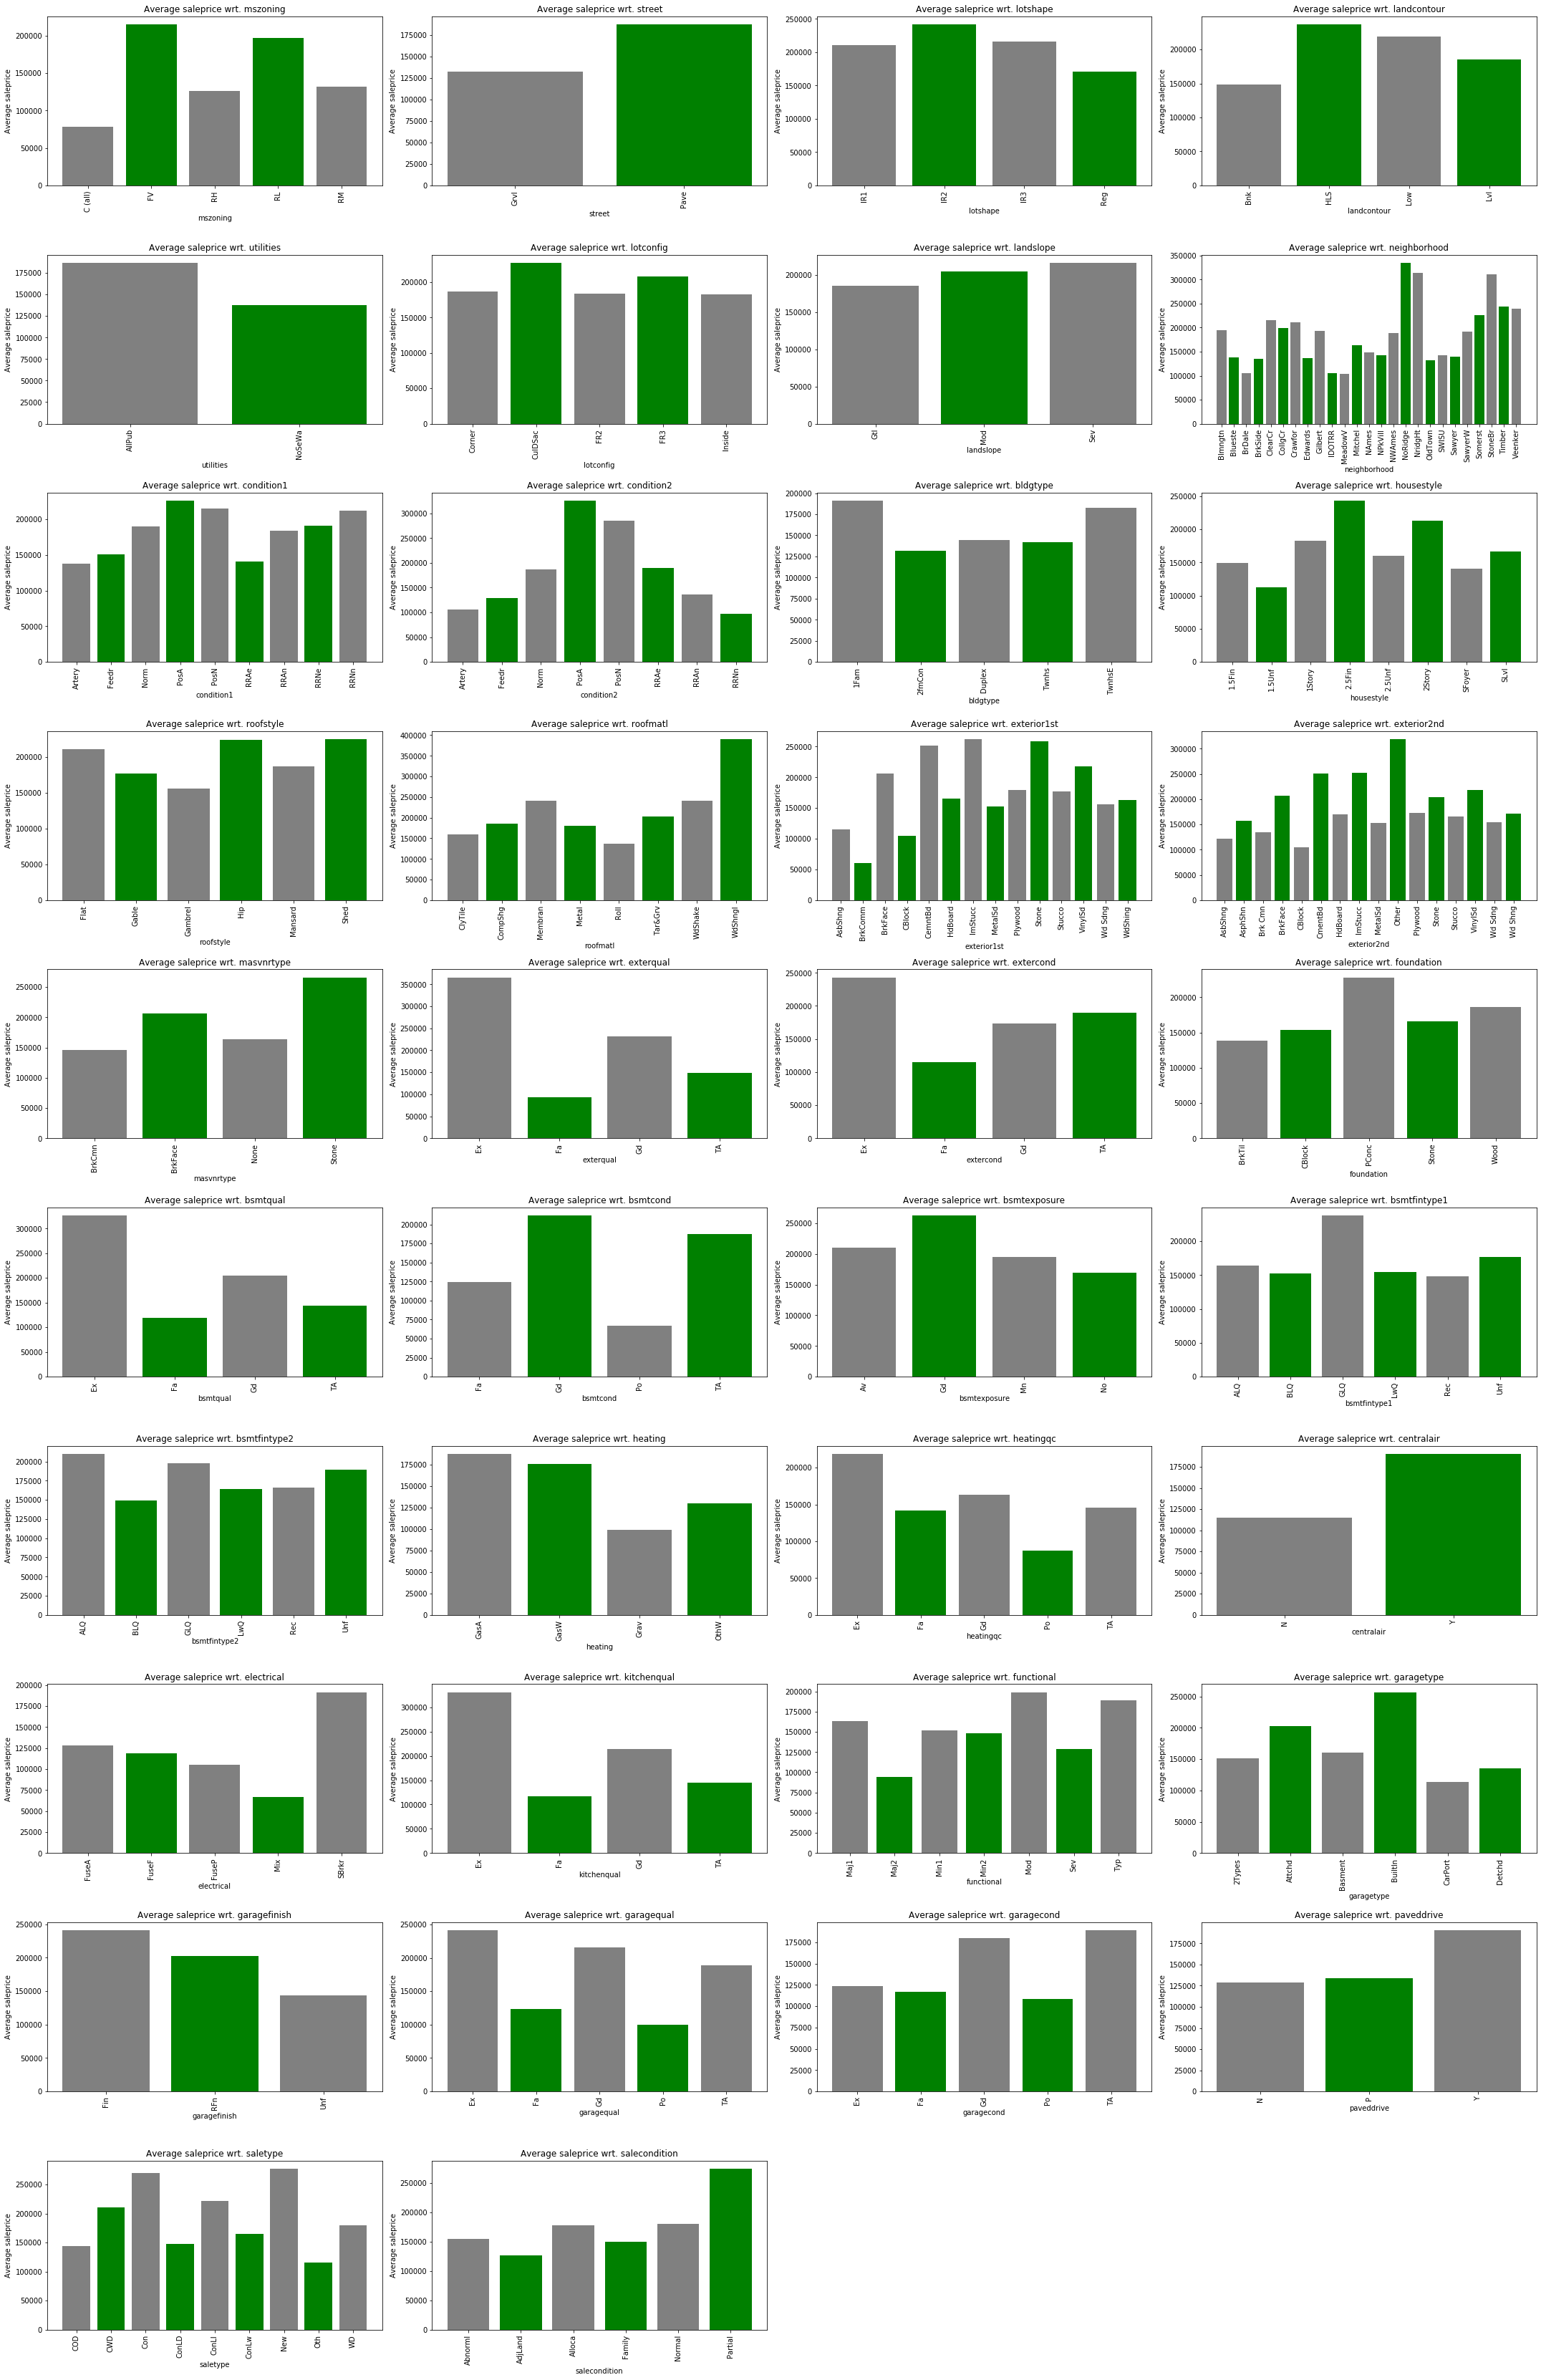

<IPython.core.display.Javascript object>

In [90]:
plt.figure(figsize=(30, 50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11, 4, index + 1)
    plt.bar(
        houseprices_df.groupby(column)["saleprice"].mean().index,
        houseprices_df.groupby(column)["saleprice"].mean(),
        color=("grey", "green"),
    )
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average saleprice")
    plt.xlabel(column)
    plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show()

It's hard to tell visually which variables are most correlated with log price.  Adam's solution was to test them all with ANOVA and look at the f-values.  This seems more quantitative and perhaps easier to decide which variables to examine further with the plots above.

In [91]:
cat_cols = houseprices_df.select_dtypes("O").copy()
anova_results = []
for col in cat_cols:
    groups = list(houseprices_df[["log_price", col]].groupby(col))
    samples = [group[1]["log_price"] for group in groups]
    f, p = stats.f_oneway(*samples)

    anova_result = {"col": col, "f": f, "p": p}
    anova_results.append(anova_result)

anova_results_df = pd.DataFrame(anova_results).sort_values("f", ascending=False)
top_f = anova_results_df.head(10)
top_f

,col,f,p
17,exterqual,371.336560,2.721252e-175
20,bsmtqual,362.389690,4.221643e-172
29,kitchenqual,352.895713,1.122393e-168
32,garagefinish,309.056384,4.991825e-111
19,foundation,134.180318,2.208245e-96
27,centralair,112.606943,2.591895e-25
26,heatingqc,98.211559,2.637966e-73
16,masvnrtype,95.262630,7.242995e-56
31,garagetype,93.156415,3.167353e-84
0,mszoning,71.611487,5.391324e-55


<IPython.core.display.Javascript object>

As I examine the histograms of the top several features in the ANOVA results, I notice that some of them appear to be correlated with each other:

* exterqual, bsmtqual, kitchenqual, and heatingqc

I, therefore, pick exterqual, garagefinish, foundation, and centralair as my categorical features.  This may be too many, and I might have to exclude more as my analysis continues....

Let's encode them.  Exterqual is ordinal, centralair is binary, the other two will need dummies.

In [96]:
cat_df = houseprices_df[["exterqual", "garagefinish", "foundation", "centralair"]]

<IPython.core.display.Javascript object>

In [93]:
houseprices_df["centralair"] = (houseprices_df["centralair"] == "Y").astype(int)

<IPython.core.display.Javascript object>

In [94]:
quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
houseprices_df[["exterqual"]] = houseprices_df[["exterqual"]].replace(quality_map)

<IPython.core.display.Javascript object>

In [98]:
garage_df = pd.get_dummies(cat_df["garagefinish"], drop_first=True)

<IPython.core.display.Javascript object>

In [100]:
foundation_df = pd.get_dummies(cat_df["foundation"], drop_first=True)

<IPython.core.display.Javascript object>

In [102]:
high_corr_num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1459
Data columns (total 8 columns):
log_price       1334 non-null float64
overallqual     1334 non-null int64
grlivarea       1334 non-null int64
garagecars      1334 non-null int64
garagearea      1334 non-null int64
fullbath        1334 non-null int64
yearbuilt       1334 non-null int64
totrmsabvgrd    1334 non-null int64
dtypes: float64(1), int64(7)
memory usage: 133.8 KB


<IPython.core.display.Javascript object>

In [105]:
cat_df.drop(index=drop_ids, inplace=True)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1459
Data columns (total 4 columns):
exterqual       1334 non-null int64
garagefinish    1334 non-null object
foundation      1334 non-null object
centralair      1334 non-null int64
dtypes: int64(2), object(2)
memory usage: 52.1+ KB


<IPython.core.display.Javascript object>

In [106]:
garage_df.drop(index=drop_ids, inplace=True)
garage_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1459
Data columns (total 2 columns):
RFn    1334 non-null uint8
Unf    1334 non-null uint8
dtypes: uint8(2)
memory usage: 13.0 KB


<IPython.core.display.Javascript object>

In [107]:
foundation_df.drop(index=drop_ids, inplace=True)
foundation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1459
Data columns (total 4 columns):
CBlock    1334 non-null uint8
PConc     1334 non-null uint8
Stone     1334 non-null uint8
Wood      1334 non-null uint8
dtypes: uint8(4)
memory usage: 15.6 KB


<IPython.core.display.Javascript object>

In [113]:
hp_df = pd.concat([high_corr_num_df, cat_df, garage_df, foundation_df], axis=1)
hp_df.drop(columns=["garagefinish", "foundation"], inplace=True)

<IPython.core.display.Javascript object>

In [115]:
display(hp_df.head(20))
hp_df.describe()

,log_price,overallqual,grlivarea,garagecars,garagearea,fullbath,yearbuilt,totrmsabvgrd,exterqual,centralair,RFn,Unf,CBlock,PConc,Stone,Wood
0,12.247694,7,1710,2,548,2,2003,8,3,1,1,0,0,1,0,0
1,12.109011,6,1262,2,460,2,1976,6,2,1,1,0,1,0,0,0
2,12.317167,7,1786,2,608,2,2001,6,3,1,1,0,0,1,0,0
3,11.849398,7,1717,3,642,1,1915,7,2,1,0,1,0,0,0,0
4,12.429216,8,2198,3,836,2,2000,9,3,1,1,0,0,1,0,0
5,11.870600,5,1362,2,480,1,1993,5,2,1,0,1,0,0,0,1
6,12.634603,8,1694,2,636,2,2004,7,3,1,1,0,0,1,0,0
7,12.206073,7,2090,2,484,2,1973,7,2,1,1,0,1,0,0,0
8,11.774520,7,1774,2,468,2,1931,8,2,1,0,1,0,0,0,0
9,11.678440,5,1077,1,205,1,1939,5,2,1,1,0,0,0,0,0


,log_price,overallqual,grlivarea,garagecars,garagearea,fullbath,yearbuilt,totrmsabvgrd,exterqual,centralair,RFn,Unf,CBlock,PConc,Stone,Wood
count,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000
mean,12.061309,6.208396,1527.870315,1.868816,499.994753,1.571964,1972.944528,6.537481,2.423538,0.954273,0.309595,0.434783,0.434783,0.461769,0.004498,0.002249
std,0.373110,1.310144,489.312662,0.632955,184.628722,0.544075,29.565342,1.569980,0.571714,0.208971,0.462500,0.495914,0.495914,0.498723,0.066939,0.047387
min,10.471950,2.000000,438.000000,1.000000,160.000000,0.000000,1880.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.813030,5.000000,1158.250000,1.000000,375.500000,1.000000,1956.000000,5.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.034691,6.000000,1479.000000,2.000000,484.000000,2.000000,1976.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.301383,7.000000,1788.000000,2.000000,581.000000,2.000000,2001.000000,7.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,13.345507,10.000000,3627.000000,4.000000,1390.000000,3.000000,2010.000000,12.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

### Data is cleaned and ready to model!

In [116]:
# Adam's helper function
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [121]:
print_vif(hp_df.drop(columns=["log_price"]))

VIF results
-------------------------------
const           18044.394921
overallqual         3.125425
grlivarea           4.778927
garagecars          4.178694
garagearea          3.518519
fullbath            2.354102
yearbuilt           4.385924
totrmsabvgrd        3.398150
exterqual           2.523801
centralair          1.220862
RFn                 1.633258
Unf                 2.525677
CBlock              4.946696
PConc               7.124127
Stone               1.074063
Wood                1.062713
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Some issues with the PConc feature, but let's move on...

In [123]:
X = hp_df.drop(columns=["log_price"])
y = hp_df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32
)

<IPython.core.display.Javascript object>

In [124]:
model = LinearRegression()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.8274170037105136
test_score: 0.8445654729289171


<IPython.core.display.Javascript object>

In [125]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     335.9
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:36:37   Log-Likelihood:                 483.74
No. Observations:                1067   AIC:                            -935.5
Df Residuals:                    1051   BIC:                            -855.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.3974      0.646     11.458      0.000       6.131       8.664
overallqual      0.0859      0.006     13.632      0.000       0.074       0.098
grlivarea        0.0003    2.2e-05     15.450      0.000       0.000       0.000
garagecars       0.0284      0.016      1.779      0.076      -0.003       0.060
garagearea       0.0002   4.95e-05      4.229      0.000       0.000       0.000
fullbath        -0.0441      0.014     -3.206      0.001      -0.071      -0.017
yearbuilt        0.0016      0.000      4.798      0.000       0.001       0.002
totrmsabvgrd    -0.0077      0.006     -1.350      0.177      -0.019       0.003
exterqual        0.0755      0.013      5.729      0.000       0.050       0.101
centralair       0.1865      0.025      7.521      0.000       0.138       0.235
RFn             -0.0183      0.013     -1.394      0.164      -0.044       0.007
Unf             -0.0666      0.015     -4.410      0.000      -0.096      -0.037
CBlock           0.0297      0.021      1.413      0.158      -0.012       0.071
PConc            0.0183      0.025      0.723      0.470      -0.031       0.068
Stone           -0.0619      0.080     -0.775      0.439      -0.219       0.095
Wood            -0.1765      0.112     -1.571      0.116      -0.397       0.044
==============================================================================
Omnibus:                      142.639   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.977
Skew:                          -0.624   Prob(JB):                    1.99e-108
Kurtosis:                       6.098   Cond. No.                     3.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

It looks like the p-values of garagecars, totrmsabvgrd, and the foundation features are too high and so I'll drop those and redo the analysis to see if my results change...

In [130]:
X2 = hp_df.drop(
    columns=[
        "log_price",
        "garagecars",
        "totrmsabvgrd",
        "CBlock",
        "PConc",
        "Stone",
        "Wood",
        "RFn",
    ]
)
y2 = hp_df["log_price"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=32
)

<IPython.core.display.Javascript object>

In [131]:
model = LinearRegression()
model.fit(X2_train, y2_train)

train_score = model.score(X2_train, y2_train)
test_score = model.score(X2_test, y2_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.825173504077499
test_score: 0.8423353600875172


<IPython.core.display.Javascript object>

In [132]:
X2_train_const = sm.add_constant(X2_train)
lm = sm.OLS(y2_train, X2_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     624.2
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:44:02   Log-Likelihood:                 476.85
No. Observations:                1067   AIC:                            -935.7
Df Residuals:                    1058   BIC:                            -890.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.8091      0.500     13.619      0.000       5.828       7.790
overallqual     0.0862      0.006     13.977      0.000       0.074       0.098
grlivarea       0.0003   1.53e-05     21.281      0.000       0.000       0.000
garagearea      0.0003   3.27e-05      8.353      0.000       0.000       0.000
fullbath       -0.0485      0.013     -3.643      0.000      -0.075      -0.022
yearbuilt       0.0019      0.000      7.365      0.000       0.001       0.002
exterqual       0.0725      0.013      5.645      0.000       0.047       0.098
centralair      0.1918      0.024      7.862      0.000       0.144       0.240
Unf            -0.0558      0.013     -4.459      0.000      -0.080      -0.031
==============================================================================
Omnibus:                      133.108   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              458.805
Skew:                          -0.582   Prob(JB):                    2.35e-100
Kurtosis:                       5.994   Cond. No.                     2.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>